# Cosmic Ray Track Finder

This is a primitive track finder in CCD images. It thresholds the image to find "blobs" above threshold and then loops through all found blobs to group them according to their separation distance.

If one really wants to look for line-like features to ID muon tracks, a better approach for grouping blobs could be something like a Hough transform.

A simple calculation of the principal moments of the blob groups is available in the classes provided but is not used in this notebook. Those calculations are based on the paper "[Cosmic rays and other nonsense in astronomical CCD imagers](https://link.springer.com/article/10.1023/A:1026196806990)" by Don Groom, Exp. Astron. **14**:55, 2002. The code was written for the [DECO](https://wipac.wisc.edu/deco/home) high-school outreach program at UW-Madison in 2013.

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure

from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

## Blob Class

Basic data class to store blob position and contour lines. Basically just a dumb "struct."

In [3]:
class Blob:
    """Class that defines a 'blob' in an image: the contour of a set of pixels
       with values above a given threshold.
       """

    def __init__(self, x, y):
        """Define a counter by its contour lines (an list of points in the xy
           plane), the contour centroid, and its enclosed area.
           
           Parameters
           ----------
           x : list or array_like
               x-values of blob contour.
           y : list or array_like
               y-values of blob contour.
           """
        self.x = x
        self.y = y
        self.xc = np.mean(x)
        self.yc = np.mean(y)

        # Find the area inside the contour
        self.area = 0.
        n = len(x)
        for i in range(0, n):
            self.area += 0.5*(y[i]+y[i-1])*(x[i]-x[i-1])

    def distance(self, blob):
        """Calculate the distance between the centroid of this blob contour and
        another one in the xy plane.
           
        Parameters
        ----------
        blob : Blob
            A second blob.
               
        Returns
        -------
        dist : float
            Euclidean distance between two blob centroids.
        """
        return np.sqrt((self.xc - blob.xc)**2 + (self.yc-blob.yc)**2)

## BlobGroup Class

Class that stores groups of blobs chained together based on their distance in the x-y plane, built using the `groupBlobs` function. Has some functions to compute the principal moments of the group of blobs.

In [4]:
class BlobGroup:
    """A list of blobs that is grouped or associated in some way, i.e., if
    their contour centroids are relatively close together."""

    def __init__(self):
        """Initialize a list of stored blobs and the bounding rectangle which
        defines the group.
        """
        self.blobs = []
        self.xmin =  1e10
        self.xmax = -1e10
        self.ymin =  1e10
        self.ymax = -1e10

    def addBlob(self, blob):
        """Add a blob to the group and enlarge the bounding rectangle of the
        group.
        """
        self.blobs.append(blob)
        self.xmin = min(self.xmin, blob.x.min())
        self.xmax = max(self.xmax, blob.x.max())
        self.ymin = min(self.ymin, blob.y.min())
        self.ymax = max(self.ymax, blob.y.max())
        self.cov  = None

    def getBoundingBox(self):
        """Get the bounding rectangle of the group."""
        return (self.xmin, self.xmax, self.ymin, self.ymax)

    def getSquareBoundingBox(self):
        """Get the bounding rectangle, redefined to give it a square aspect
        ratio."""
        xmin, xmax, ymin, ymax = (self.xmin, self.xmax, self.ymin, self.ymax)
        xL = np.abs(xmax - xmin)
        yL = np.abs(ymax - ymin)
        if xL > yL:
            ymin -= 0.5*(xL-yL)
            ymax += 0.5*(xL-yL)
        else:
            xmin -= 0.5*(yL-xL)
            xmax += 0.5*(yL-xL)
        return (xmin, xmax, ymin, ymax)
    
    def getSubImage(self, image):
        """Given an image, extract the section of the image corresponding to
        the bounding box of the blob group.
        """
        ny,nx = image.shape
        x0,x1,y0,y1 = self.getBoundingBox()

        # Account for all the weird row/column magic in the image table...
        i0,i1 = [ny - int(t) for t in (y1,y0)]
        j0,j1 = [int(t) for t in (x0,x1)]

        # Add a pixel buffer around the bounds, and check the ranges
        buf = 1
        i0 = 0 if i0-buf < 0 else i0-buf
        i1 = ny-1 if i1 > ny-1 else i1+buf
        j0 = 0 if j0-buf < 0 else j0-buf
        j1 = nx-1 if j1 > nx-1 else j1+buf

        return image[i0:i1, j0:j1]

    def getRawMoment(self, image, p, q):
        """Calculate the image moment given by
        M_{ij}=\sum_x\sum_y x^p y^q I(x,y)
        where I(x,y) is the image intensity at location x,y.
        """
        nx,ny = image.shape
        Mpq = 0.
        if p == 0 and q == 0:
            Mpq = np.sum(image)
        else:
            for i in range(0,nx):
                x = 0.5 + i
                for j in range(0,ny):
                    y = 0.5 + j
                    Mpq += x**p * y**q * image[i,j]
        return Mpq
    
    def getCovariance(self, image):
        """Get the raw moments of the image region inside the bounding box
        defined by this blob group and calculate the image covariance
        matrix."""
        if self.cov is None:
            subImage = self.getSubImage(image).transpose()
            M00 = self.getRawMoment(subImage, 0, 0)
            M10 = self.getRawMoment(subImage, 1, 0)
            M01 = self.getRawMoment(subImage, 0, 1)
            M11 = self.getRawMoment(subImage, 1, 1)
            M20 = self.getRawMoment(subImage, 2, 0)
            M02 = self.getRawMoment(subImage, 0, 2)
            xbar = M10/M00
            ybar = M01/M00
            self.cov = np.vstack([[M20/M00 - xbar*xbar, M11/M00 - xbar*ybar],
                                  [M11/M00 - xbar*ybar, M02/M00 - ybar*ybar]])
        return self.cov

    def getPrincipalMoments(self, image):
        """Return the maximum and minimum eigenvalues of the covariance matrix,
        as well as the angle theta between the maximum eigenvector and the
        x-axis."""
        cov = self.getCovariance(image)
        u20 = cov[0,0]
        u11 = cov[0,1]
        u02 = cov[1,1]

        theta = 0.5 * np.arctan2(2*u11, u20-u02)
        l1 = 0.5*(u20+u02) + 0.5*np.sqrt(4*u11**2 + (u20-u02)**2)
        l2 = 0.5*(u20+u02) - 0.5*np.sqrt(4*u11**2 + (u20-u02)**2)
        return l1, l2, theta

## Find and Group Blobs

Two functions to find blobs using a threshhold.

`findBlobs` uses the marching squares algorithm to identify a blob's outer contours.

`groupBlobs` is called after `findBlobs` and just loops over all blobs ID-ed in the image and agglomerates anything within a given distance threshold of another blob.

In [5]:
def findBlobs(image, threshold, minArea=2.):
    """Pass through an image and find a set of blobs/contours above a set
    threshold value.  The minArea parameter is used to exclude blobs with an
    area below this value.
    """
    blobs = []
    ny, nx = image.shape

    # Find contours using the Marching Squares algorithm in the scikit package.
    contours = measure.find_contours(image, threshold)
    for contour in contours:
        x = contour[:,1]
        y = ny - contour[:,0]
        blob = Blob(x, y)
        if blob.area >= minArea:
            blobs.append(blob)
    return blobs

In [6]:
def groupBlobs(blobs, maxDist):
    """Given a list of blobs, group them by distance between the centroids of
    any two blobs.  If the centroids are more distant than maxDist, create a
    new blob group.
    """
    n = len(blobs)
    groups = []
    if n >= 1:
        # Single-pass clustering algorithm: make the first blob the nucleus of
        # a blob group.  Then loop through each blob and add either add it to
        # this group (depending on the distance measure) or make it the
        # nucleus of a new blob group
        bg = BlobGroup()
        bg.addBlob(blobs[0])
        groups.append(bg)

        for i in range(1, n):
            bi = blobs[i]
            isGrouped = False
            for group in groups:
                # Calculate distance measure for a blob and a blob group:
                # blob just has to be < maxDist from any other blob in the group
                for bj in group.blobs:
                    if bi.distance(bj) < maxDist:
                        group.addBlob(bi)
                        isGrouped = True
                        break
            if not isGrouped:
                bg = BlobGroup()
                bg.addBlob(bi)
                groups.append(bg)

    return groups

## Run on Preproc Data

Access a preproc file from the redux folder on NERSC and run the blob finder on the image mask.

In [7]:
hdus = fits.open('/global/project/projectdirs/desi/spectro/redux/daily/preproc/20191208/00031136/preproc-z3-00031136.fits')
for hdu in hdus:
    print(hdu.header['EXTNAME'])

IMAGE
IVAR
MASK
READNOISE
FIBERMAP


In [8]:
img = hdus['IMAGE'].data
mask = hdus['MASK'].data
readnoise = hdus['READNOISE'].data

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


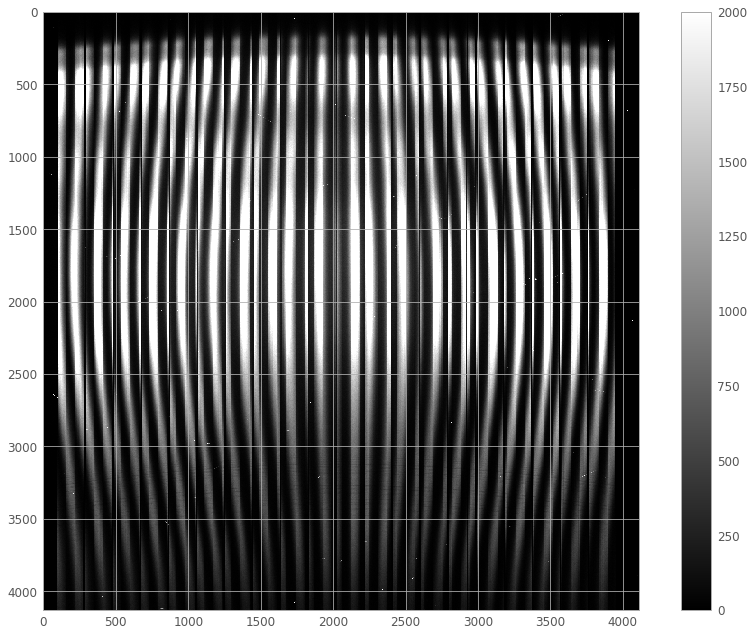

In [9]:
plt.subplots(1,1, figsize=(12,9), tight_layout=True)
plt.imshow(img, cmap='gray', vmin=0, vmax=2000)
plt.colorbar()

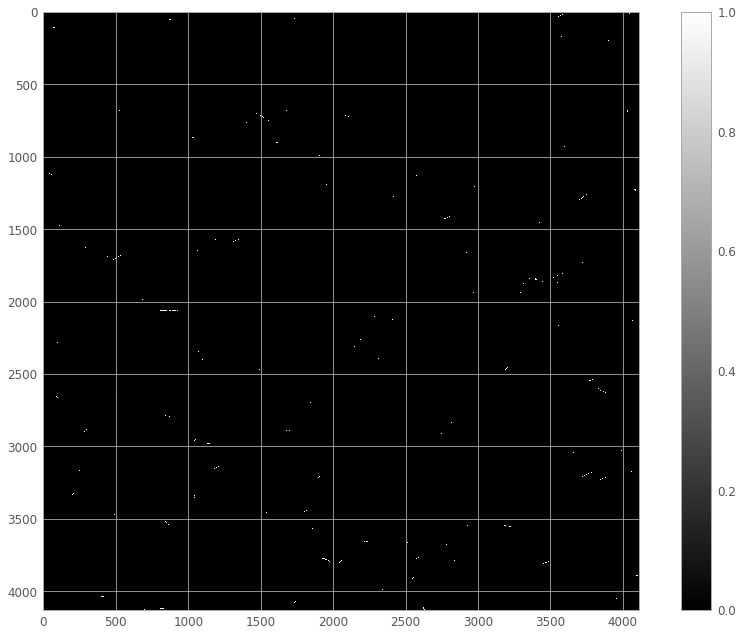

In [10]:
plt.subplots(1,1, figsize=(12,9), tight_layout=True)
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
plt.colorbar()

### Find and Group Blobs

ID blobs as regions above a threshold, and choose a minimum area to avoid identifying noisy individual pixels. The threshold used was tuned (barely) by visual inspection of the result.

The group blobs according to the Euclidean distance between them, up to some maximum distance in pixel space. Again, this was tuned in a very crude way by looking at the output.

In [11]:
blobs = findBlobs(mask, threshold=0.5, minArea=2)
groups = groupBlobs(blobs, maxDist=30.)

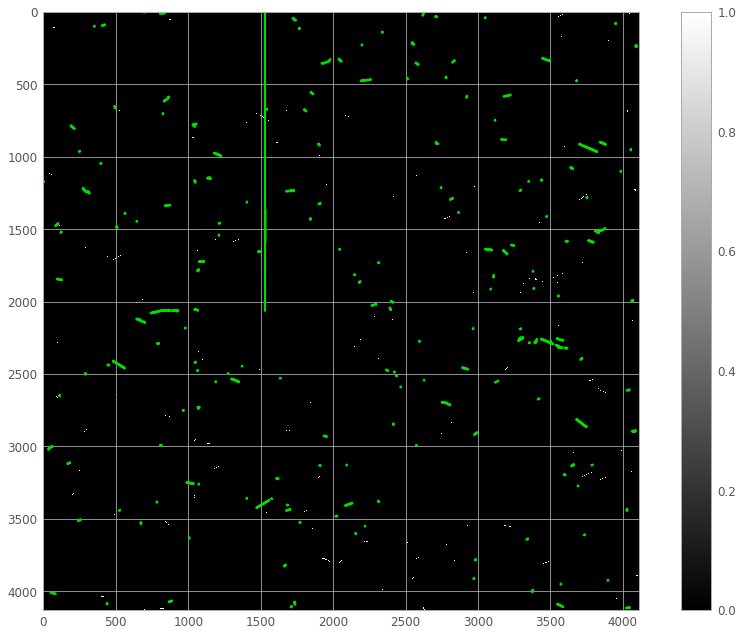

In [12]:
plt.subplots(1,1, figsize=(12,9), tight_layout=True)
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)

for blob in blobs:
    plt.plot(blob.x, blob.y, linewidth=2, color='#00dd00')
    
plt.colorbar()

### Plot Largest Blob Groups

Loop through blobs and highlight anything that is an agglomeration of more than 5 individual blobs.

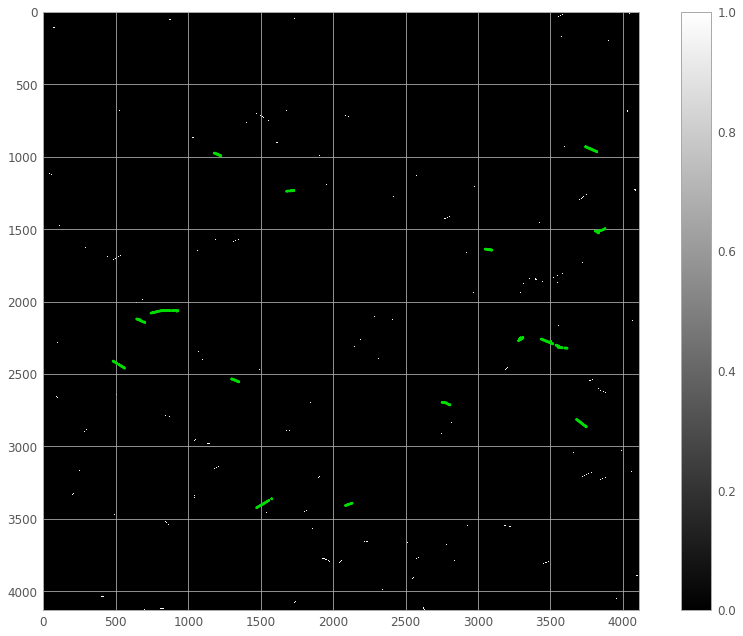

In [13]:
plt.subplots(1,1, figsize=(12,9), tight_layout=True)
plt.imshow(mask, cmap='gray', vmin=0, vmax=1.)

for i, group in enumerate(groups):
    if len(group.blobs) > 5:
        for blob in group.blobs:
            plt.plot(blob.x, blob.y, linewidth=2, color='#00dd00')

plt.colorbar()